#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


In [2]:
data=pd.read_csv('combined_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [3]:
data[:5].to_dict()

{'label': {0: 1, 1: 1, 2: 0, 3: 1, 4: 0},
 'text': {0: 'ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadron heft quell yoghurt bunkmate divert afterimage',
  1: "wulvob get your medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt have you ever stopped to wonder how much an average man pays for his mediecines ap painkillers drugs to improve the quality of life weight reducing tablets and many more escapenumber what's worse the same mediucine costs a lot more if it is branded rfwur are you intrested so http dmvrwm remunerativ net dfuaeirxygiq visit our

In [4]:
import re

###  Предобработка данных  + лемматизация

In [5]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Удаляем пунктуацию
    text = re.sub(r'\d+', '', text)      # Удаляем числа
    text = text.lower()                  # Приводим к нижнему регистру
    
    # Токенизация
    words = nltk.word_tokenize(text)
    
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Лемматизация
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(lemmatized_words)

# Применение предобработки к текстам
data['cleaned_text'] = data['text'].apply(preprocess_text)

Лемматизация — это процесс приведения слова к его начальной форме, или лемме. В отличие от стемминга, который просто обрезает окончания слов, лемматизация учитывает контекст и грамматические особенности, чтобы получить правильную базовую форму слова. 

In [6]:
data.head()

,label,text,cleaned_text
0,1,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,thanks answer guy know checked rsync manual wo...


In [7]:
data[['cleaned_text','text']][10:11].to_dict()

{'cleaned_text': {10: 'dear fellow feel insecure penis size need new improved megadik penis enlargement pill please read know megadik featured leading men magazine fhm maxim plus many others rated escapenumber choice penis enlargement gain escapenumber inch length increase penis width girth upto escapenumber produce stronger rock hard erection escapenumber safe take side effect doctor approved recommended fast shipping worldwide nothing lose lot gain http slasy net regard escapelong remains escapelong use escapenumberf milliescapenumberns escapenumberf peescapenumberple wescapenumberrld escapelong man alescapenumberng thescapenumberse milliescapenumberns although far perfect especially precludes vast waldron'},
 'text': {10: 'my dear fellow do you feel insecure about your penis size you need our new improved megadik penis enlargement pills please read on did you know megadik was featured in leading mens magazines such as fhm maxim plus many others and rated no escapenumber choice for p

In [8]:
X = data['cleaned_text']
y = data['label']
data.shape

(83448, 3)

In [35]:
y.unique()

array([1, 0])

### Train test split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X,y,test_size=0.2, random_state=42)
print(len(X_train)/len(X_test))
print(X_train.shape, X_test.shape)

3.999880167765129
(66758,) (16690,)


### BOW 

CountVectorizer (BOW) - метод веткоризации текста, работающий по принципу мешка слов, создает словарь всех уникальных слов в корпусе текстов и затем представляет каждый текст как вектор, где каждое измерение соответствует количеству вхождений слова из словаря в данном тексте.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [11]:
X_train_bow.shape

(66758, 252978)

In [12]:
print(X_train_bow[:10].toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### TF-IDF

TF-IDF — это метод векторизации текста, который учитывает не только частоту слов в документе, но и их распространенность в других документах. Это позволяет более точно оценить важность слова в контексте всего корпуса текстов

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Кросс-валидация и обучение моделей

#### bow

In [ ]:
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings("ignore")

In [16]:
log_reg_model = LogisticRegression(max_iter=100)

# Определение параметров для GridSearchCV
param_grid_bow = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# GridSearchCV для Логистической регрессии с BoW
grid_search_bow = GridSearchCV(log_reg_model, param_grid_bow, cv=5, scoring='accuracy')
grid_search_bow.fit(X_train_bow, y_train)

# Результаты
best_model_bow = grid_search_bow.best_estimator_
y_pred_bow = best_model_bow.predict(X_test_bow)

print("Logistic Regression (BoW)")
print("Best parameters:", grid_search_bow.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bow))
print("\n")

Logistic Regression (BoW)
Best parameters: {'C': 0.1, 'solver': 'liblinear'}
Accuracy: 0.9807070101857399
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7938
           1       0.97      0.99      0.98      8752

    accuracy                           0.98     16690
   macro avg       0.98      0.98      0.98     16690
weighted avg       0.98      0.98      0.98     16690

Confusion Matrix:
 [[7693  245]
 [  77 8675]]




In [17]:
rand_for = RandomForestClassifier()

# Определение параметров для GridSearchCV
param_grid_bow = {
        'n_estimators': [50, 100],
        'max_depth': [5,10]
}

# GridSearchCV для Random forest с BoW
grid_search_bow = GridSearchCV(rand_for, param_grid_bow, cv=5, scoring='accuracy')
grid_search_bow.fit(X_train_bow, y_train)

# Результаты
best_model_bow = grid_search_bow.best_estimator_
y_pred_bow = best_model_bow.predict(X_test_bow)

print("RandomForestClassifier (BoW)")
print("Best parameters:", grid_search_bow.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bow))
print("\n")

RandomForestClassifier (BoW)
Best parameters: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.8639304973037747
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      7938
           1       0.80      0.99      0.88      8752

    accuracy                           0.86     16690
   macro avg       0.89      0.86      0.86     16690
weighted avg       0.89      0.86      0.86     16690

Confusion Matrix:
 [[5740 2198]
 [  73 8679]]




In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
### Lightgbm ожидает float, поэтому надо float
X_train_bow = X_train_bow.astype(np.float32)
X_test_bow = X_test_bow.astype(np.float32)
# Создаем модель LGBM
lgbm = LGBMClassifier()

# Определяем параметры для GridSearchCV
param_grid_bow = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# GridSearchCV для LightGBM с BoWs
grid_search_bow = GridSearchCV(lgbm, param_grid_bow, cv=5, scoring='accuracy')
grid_search_bow.fit(X_train_bow, y_train)

# Результаты
best_model_bow = grid_search_bow.best_estimator_
y_pred_bow = best_model_bow.predict(X_test_bow)



In [36]:
# Выводим результаты
print("LGBMClassifier (BoW)")
print("Best parameters:", grid_search_bow.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bow))


LGBMClassifier (BoW)
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.9579988016776513
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      7938
           1       0.93      0.99      0.96      8752

    accuracy                           0.96     16690
   macro avg       0.96      0.96      0.96     16690
weighted avg       0.96      0.96      0.96     16690

Confusion Matrix:
 [[7309  629]
 [  72 8680]]


#### tfidf

Возьмем лучшие гиперпараметры из BOW

In [40]:
log_reg=LogisticRegression(max_iter=100, C=0.1, solver='liblinear')
log_reg.fit(X_train_tfidf, y_train)
y_pred = best_model_bow.predict(X_test_tfidf)

print("Logistic Regression (TFIDF)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")

Logistic Regression (TFIDF)
Accuracy: 0.9532654284002396
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7938
           1       0.92      0.99      0.96      8752

    accuracy                           0.95     16690
   macro avg       0.96      0.95      0.95     16690
weighted avg       0.96      0.95      0.95     16690

Confusion Matrix:
 [[7228  710]
 [  70 8682]]




In [42]:
rand_for=RandomForestClassifier(max_depth=10, n_estimators=100)
rand_for.fit(X_train_tfidf, y_train)
y_pred = best_model_bow.predict(X_test_tfidf)

print("Decision Tree (TF-IDF)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")

Decision Tree (TF-IDF)
Accuracy: 0.9532654284002396
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7938
           1       0.92      0.99      0.96      8752

    accuracy                           0.95     16690
   macro avg       0.96      0.95      0.95     16690
weighted avg       0.96      0.95      0.95     16690

Confusion Matrix:
 [[7228  710]
 [  70 8682]]




In [ ]:
rand_for=LGBMClassifier(max_depth=5, n_estimators=100, learning_rate=0.1)
rand_for.fit(X_train_tfidf, y_train)
y_pred = best_model_bow.predict(X_test_tfidf)



In [45]:
print("Lightgbm (TF-IDF)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")

Lightgbm (TF-IDF)
Accuracy: 0.9532654284002396
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7938
           1       0.92      0.99      0.96      8752

    accuracy                           0.95     16690
   macro avg       0.96      0.95      0.95     16690
weighted avg       0.96      0.95      0.95     16690

Confusion Matrix:
 [[7228  710]
 [  70 8682]]




В проведнных экспериментах лучше всего себя показал Log Reg с Acc=0.98, с использованием фичей с BOW

## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

In [4]:
import numpy as np
import matplotlib.pyplot as plt

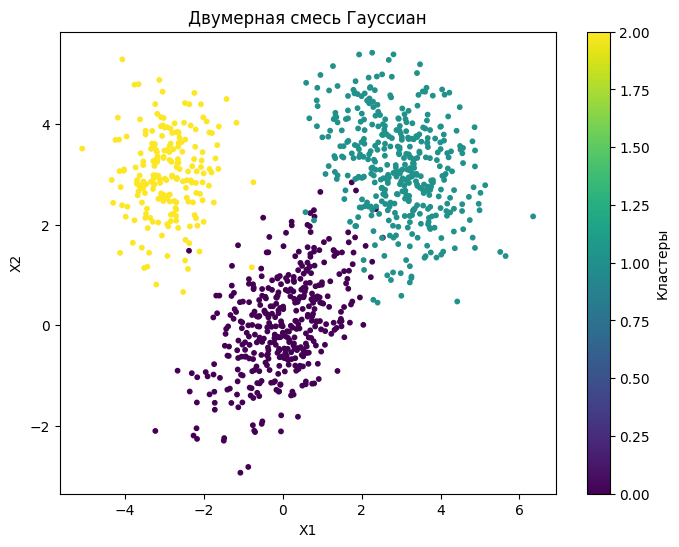

In [5]:
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Количество кластеров: 2, Индекс Силуэта: 0.5070
Количество кластеров: 3, Индекс Силуэта: 0.6064
Количество кластеров: 4, Индекс Силуэта: 0.4879
Количество кластеров: 5, Индекс Силуэта: 0.4312
Количество кластеров: 6, Индекс Силуэта: 0.4089
Количество кластеров: 7, Индекс Силуэта: 0.3926
Количество кластеров: 8, Индекс Силуэта: 0.3792
Количество кластеров: 9, Индекс Силуэта: 0.3868
Количество кластеров: 10, Индекс Силуэта: 0.3328


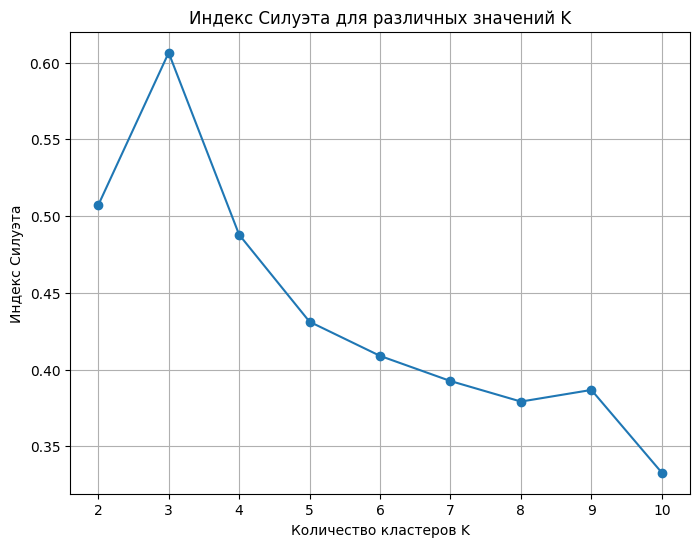

Оптимальное количество кластеров K: 3


In [7]:
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Количество кластеров: {n_clusters}, Индекс Силуэта: {silhouette_avg:.4f}")
    
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Индекс Силуэта для различных значений K')
plt.xlabel('Количество кластеров K')
plt.ylabel('Индекс Силуэта')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()

optimal_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Оптимальное количество кластеров K: {optimal_k}")

**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score
eps_values = np.arange(0.1, 1.5, 0.1)
min_samples_values = range(2, 11)
best_f1 = 0
best_params = (None, None)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X)

        if len(set(cluster_labels)) > 1:  #
   
            f1 = accuracy_score(labels, cluster_labels)
            print(f"eps: {eps:.1f}, min_samples: {min_samples}, F1 Score: {f1:.4f}")

            if f1 > best_f1:
                best_f1 = f1
                best_params = (eps, min_samples)

print(f"Лучшие параметры: eps = {best_params[0]}, min_samples = {best_params[1]}, F1 Score = {best_f1:.4f}")


eps: 0.1, min_samples: 2, F1 Score: 0.0050
eps: 0.1, min_samples: 3, F1 Score: 0.0050
eps: 0.1, min_samples: 4, F1 Score: 0.0050
eps: 0.1, min_samples: 5, F1 Score: 0.0090
eps: 0.1, min_samples: 6, F1 Score: 0.0080
eps: 0.1, min_samples: 7, F1 Score: 0.0070
eps: 0.2, min_samples: 2, F1 Score: 0.2710
eps: 0.2, min_samples: 3, F1 Score: 0.2710
eps: 0.2, min_samples: 4, F1 Score: 0.2640
eps: 0.2, min_samples: 5, F1 Score: 0.2490
eps: 0.2, min_samples: 6, F1 Score: 0.2300
eps: 0.2, min_samples: 7, F1 Score: 0.2290
eps: 0.2, min_samples: 8, F1 Score: 0.1140
eps: 0.2, min_samples: 9, F1 Score: 0.1020
eps: 0.2, min_samples: 10, F1 Score: 0.0640
eps: 0.3, min_samples: 2, F1 Score: 0.3370
eps: 0.3, min_samples: 3, F1 Score: 0.3370
eps: 0.3, min_samples: 4, F1 Score: 0.3370
eps: 0.3, min_samples: 5, F1 Score: 0.3360
eps: 0.3, min_samples: 6, F1 Score: 0.3100
eps: 0.3, min_samples: 7, F1 Score: 0.3020
eps: 0.3, min_samples: 8, F1 Score: 0.6070
eps: 0.3, min_samples: 9, F1 Score: 0.5800
eps: 0.3, 

**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

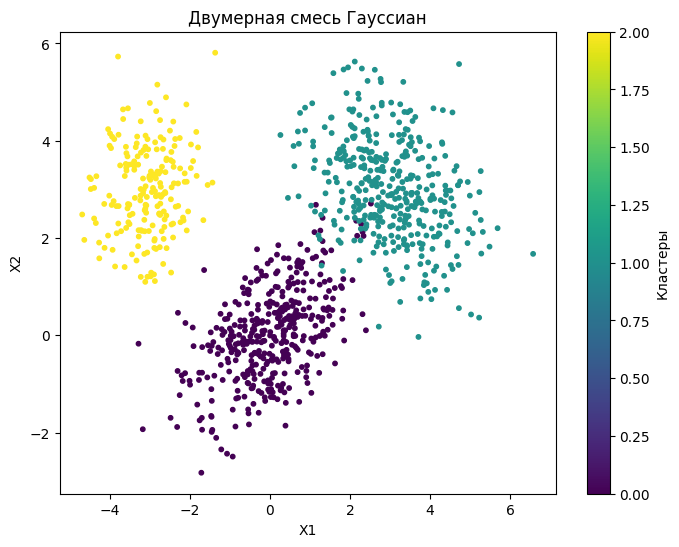

Сходимость достигнута на итерации 22


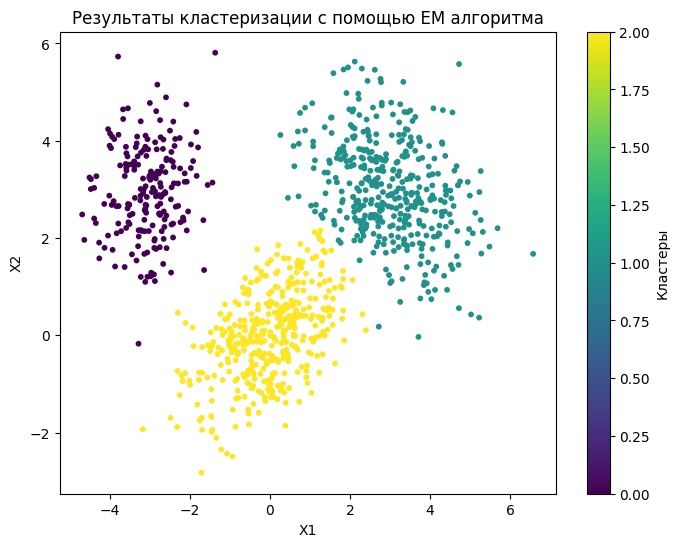

In [ ]:
from scipy.stats import multivariate_normal


X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

# Реализация EM алгоритма
def initialize_parameters(X, n_clusters):
    n_samples, n_features = X.shape
    pi = np.ones(n_clusters) / n_clusters  # Начальные веса кластеров
    mu = X[np.random.choice(n_samples, n_clusters, replace=False)]  # Случайные центры кластеров
    sigma = np.array([np.eye(n_features) for _ in range(n_clusters)])  # Начальные ковариационные матрицы
    return pi, mu, sigma

def e_step(X, pi, mu, sigma):
    n_samples = X.shape[0]
    n_clusters = pi.shape[0]
    
    # Вычисляем вероятность принадлежности каждого образца каждому кластеру
    gamma = np.zeros((n_samples, n_clusters))
    for k in range(n_clusters):
        gamma[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k])
    
    # Нормируем вероятности
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

def m_step(X, gamma):
    n_samples, n_features = X.shape
    n_clusters = gamma.shape[1]
    
    # Обновляем параметры кластеров
    N_k = gamma.sum(axis=0)
    pi = N_k / n_samples
    mu = np.dot(gamma.T, X) / N_k[:, np.newaxis]
    sigma = np.zeros((n_clusters, n_features, n_features))
    
    for k in range(n_clusters):
        X_centered = X - mu[k]
        sigma[k] = np.dot((gamma[:, k][:, np.newaxis] * X_centered).T, X_centered) / N_k[k]
    
    return pi, mu, sigma

def compute_log_likelihood(X, pi, mu, sigma):
    n_samples = X.shape[0]
    n_clusters = pi.shape[0]
    
    log_likelihood = 0
    for i in range(n_samples):
        temp = 0
        for k in range(n_clusters):
            temp += pi[k] * multivariate_normal.pdf(X[i], mean=mu[k], cov=sigma[k])
        log_likelihood += np.log(temp)
    return log_likelihood

def em_algorithm(X, n_clusters, max_iter=100, tol=1e-6):
    # Инициализация параметров
    pi, mu, sigma = initialize_parameters(X, n_clusters)
    log_likelihood = -np.inf
    
    for iteration in range(max_iter):
        # E-шаг
        gamma = e_step(X, pi, mu, sigma)
        
        # M-шаг
        pi, mu, sigma = m_step(X, gamma)
        
        # Вычисляем логарифм правдоподобия
        new_log_likelihood = compute_log_likelihood(X, pi, mu, sigma)
        
        # Проверяем сходимость
        if np.abs(new_log_likelihood - log_likelihood) < tol:
            print(f"Сходимость достигнута на итерации {iteration}")
            break
        log_likelihood = new_log_likelihood
    
    return pi, mu, sigma, gamma

# Применение EM алгоритма
n_clusters = 3
pi, mu, sigma, gamma = em_algorithm(X, n_clusters)

# Прогнозируем кластеры
predicted_labels = np.argmax(gamma, axis=1)

# Визуализация результатов
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', s=10)
plt.title("Результаты кластеризации с помощью EM алгоритма")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()


**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

In [11]:
from sklearn.mixture import GaussianMixture

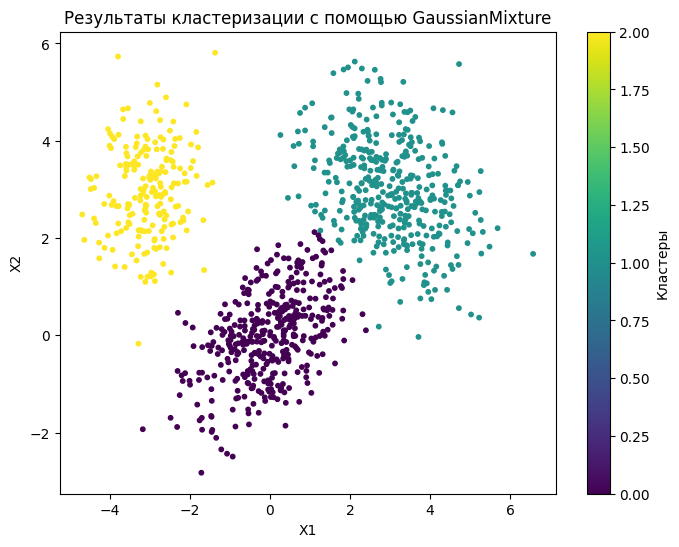

In [12]:
# Применение GaussianMixture
model = GaussianMixture(n_components=3, random_state=42)
model.fit(X)
labels_gmm = model.predict(X)

# Визуализация результатов GaussianMixture
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_gmm, cmap='viridis', s=10)
plt.title("Результаты кластеризации с помощью GaussianMixture")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()


Описание работы GaussianMixture:

GaussianMixture из sklearn реализует EM алгоритм для оценки параметров смеси Гауссовских распределений.
В отличие от самописной реализации, библиотека автоматически определяет оптимальные параметры,
поддерживает регуляризацию и вычисляет оценку правдоподобия для проверки качества модели.

Описание Алгоритма

Gaussian Mixture Model (GMM) — это статистический подход, который используется для моделирования данных как смеси нескольких многомерных нормальных распределений. GMM хорошо подходит для задач кластеризации, особенно если кластеры имеют эллиптическую форму.